In [1]:
!pip install -q kaggle

In [2]:
# this kaggle.json files is downloadable your kaggle profile> settings> create new token
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mmehmetaliyavuz","key":"2419d4c4ac3e0f0f75174473e6152735"}'}

In [3]:
!mkdir ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
# files also are downloadable on kaggle, but this way provide code to rerunableness
!kaggle datasets download -d andrewmvd/car-plate-detection

 99% 201M/203M [00:01<00:00, 167MB/s]
100% 203M/203M [00:01<00:00, 140MB/s]


In [7]:
# unzip files you download
import zipfile
def unzip(path):
    with zipfile.ZipFile(path, 'r') as files:
        files.extractall()
path = "/content/car-plate-detection.zip"
unzip(path)

In [8]:
# import main library that required
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras as keras
import tensorflow.keras
from sklearn.model_selection import train_test_split

In [9]:
# visualize one of the annotation to understand paths that needed
with open("/content/annotations/Cars105.xml","r") as files:
  data = files.read()
  print(data)


<annotation>
    <folder>images</folder>
    <filename>Cars105.png</filename>
    <size>
        <width>400</width>
        <height>240</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>licence</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>152</xmin>
            <ymin>147</ymin>
            <xmax>206</xmax>
            <ymax>159</ymax>
        </bndbox>
    </object>
</annotation>


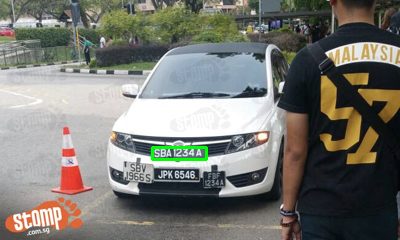

In [10]:
from google.colab.patches import cv2_imshow
import cv2
import xml.etree.ElementTree as ET

def get_value(root, *args):
    element = root
    for tag in args:
        element = element.find(tag)
        if element is None:
            return None
    return element.text

with open("/content/annotations/Cars105.xml", "r") as files:
    xml_data = files.read()

root = ET.fromstring(xml_data)

xmin = int(get_value(root, 'object', 'bndbox', 'xmin'))
ymin = int(get_value(root, 'object', 'bndbox', 'ymin'))
xmax = int(get_value(root, 'object', 'bndbox', 'xmax'))
ymax = int(get_value(root, 'object', 'bndbox', 'ymax'))

image = cv2.imread("/content/images/Cars105.png")

cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
cv2_imshow(image)

let's define a visualizer function for our data frames


In [11]:
def create_data(annot,images):
  """
  for an example we need four point on data and image with rectangle
  annot: path of annotations,
  images: path of images
  """
  import numpy as np
  import pandas as pd
  import xml.etree.ElementTree as ET
  import os
  path_annot = []
  path_images = []
  data_list = []
  def gets_path(annot,images):
    for dirpath, dirnames, filenames in os.walk(annot):
      for filename in filenames:
        pathA = os.path.join(dirpath, filename)
        path_annot.append(pathA)
    for dirpath, dirnames, filenames in os.walk(images):
      for filename in filenames:
        pathI =  os.path.join(dirpath, filename)
        path_images.append(pathI)
      return path_annot,path_images

 #this get_value function gets element from json

  def get_value(root, *args):
    element = root
    for tag in args:
        element = element.find(tag)
        if element is None:
            return None
    value = element.text
    try:
        float_value = float(value)
        int_value = int(float_value)
        return int_value
    except ValueError:
        return None

  path_annot, path_images = gets_path(annot=annot,images=images)

  jsons = []


  #these two for loop to exract features

  for path in path_annot:
    with open(path, "r") as files:
      xml_data = files.read()
      jsons.append(xml_data)

  for xml_data, filepath in zip(jsons, path_annot):

    root = ET.fromstring(xml_data)
    filename = root.find('filename').text
    xmin = int(get_value(root, 'object', 'bndbox', 'xmin'))
    ymin = int(get_value(root, 'object', 'bndbox', 'ymin'))
    xmax = int(get_value(root, 'object', 'bndbox', 'xmax'))
    ymax = int(get_value(root, 'object', 'bndbox', 'ymax'))
    data_dict = {
                "filepaths": filepath ,
                "filename": filename,
                "xmin": xmin,
                "ymin": ymin,
                "xmax": xmax,
                "ymax": ymax
            }
    data_list.append(data_dict)
  data = pd.DataFrame(data_list)
  data["imagepaths"] = data["filepaths"].str.replace("xml","png")
  data["filepaths"] = data["filepaths"].str.replace("xml","json")
  data["class_label"] = 1
  data["imagepaths"] = data["imagepaths"].str.replace("annotations","images")
  data["imagepaths"] = data["imagepaths"].str.replace("json","png")
  data = data[["filepaths","filename","imagepaths","class_label","xmin","ymin","xmax","ymax"]]
  return data

In [12]:
def visualizer(data,row):
  """
  row is row of the images that you want to visualize
  data is dataframe
  """
  import cv2
  path = data["imagepaths"][row]
  xmin = data.iloc[row,:]["xmin"]
  ymin = data.iloc[row,:]["ymin"]
  xmax = data.iloc[row,:]["xmax"]+xmin
  ymax = data.iloc[row,:]["ymax"]+ymin
  images = cv2.imread(path)
  image = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)
  cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
  cv2_imshow(image)
  return

In [13]:
def visualize_and_get(data,row):
  """
  row is row of the images that you want to visualize
  data is dataframe
  """
  import cv2

  xmin = data.iloc[row,:]["xmin"]
  ymin = data.iloc[row,:]["ymin"]
  w = data.iloc[row,:]["xmax"] - xmin
  h = data.iloc[row,:]["ymax"] - ymin
  cord = [[xmin, ymin, w, h]]
  path = data.iloc[row,:]["imagepaths"]
  filenames = data.iloc[row,:]["filename"]
  images = cv2.imread(path)
  image = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)
  cv2.rectangle(image, (xmin, ymin), (xmin + w, ymin + h), (0, 255, 0), 2)  # Fix the rectangle coordinates
  resized_image = cv2.resize(images, (450, 450))
  resized_xmin = int(xmin * 450 / image.shape[1])
  resized_ymin = int(ymin * 450 / image.shape[0])
  resized_w = int(w * 450 / image.shape[1])  # Use the original width after resizing
  resized_h = int(h * 450 / image.shape[0])  # Use the original height after resizing
  resized_cord = [[resized_xmin, resized_ymin, resized_w, resized_h]]
  return resized_image, resized_cord, filenames

In [14]:
def visualizer_transformed_image(transformed):
    """
    gets transformed or augmented image and visualize it
    """
    # Convert coordinates to integers
    x_min = int(transformed["bboxes"][0][0])
    y_min = int(transformed["bboxes"][0][1])
    x_max = int(transformed["bboxes"][0][0]) + int(transformed["bboxes"][0][2])
    y_max = int(transformed["bboxes"][0][1]) + int(transformed["bboxes"][0][3])

    # Draw rectangle
    cv2.rectangle(transformed["image"], (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    image = cv2_imshow(transformed["image"])
    return image,


In [15]:
def save_image_and_annotations(img, Bboxes,fileName , output_image_path,output_annotation_path):
  """
    take images, bboxes and class_labels , save augmented images and annotations
    img : original image
    Bboxes : original bboxes
    Classlabels : class labels default: "plate"
    output_image_path
    output_annotation_path
  """
  from PIL import Image
  import os
  import xml.etree.ElementTree as ET
  import albumentations as alb

  augmenter = alb.Compose([alb.RandomCrop(width=450, height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                       bbox_params=alb.BboxParams(format='coco',
                                                  label_fields=['class_labels']))
  class_labels = ['plate']

  transformed = augmenter(image=img, bboxes=Bboxes, class_labels=class_labels)

  filename = fileName
  transformed_image = transformed['image']
  transformed_bboxes = transformed['bboxes']
  transformed_class_labels = transformed['class_labels']
  size = transformed["image"].shape
  new_filename = "augmented_" + filename
  output_image_path = os.path.join(output_image_path, new_filename)
  cv2.imwrite(output_image_path, cv2.cvtColor(transformed_image, cv2.COLOR_RGB2BGR))

  annotation = ET.Element("annotation")
  folder = ET.SubElement(annotation, "folder")
  folder.text = "aug_images"
  filename = ET.SubElement(annotation, "filename")
  filename.text = new_filename.replace(".png","json")
  size_elem = ET.SubElement(annotation, "size")
  width_elem = ET.SubElement(size_elem, "width")
  height_elem = ET.SubElement(size_elem, "height")
  depth_elem = ET.SubElement(size_elem, "depth")
  width_elem.text = str(size[0])
  height_elem.text = str(size[1])
  depth_elem.text = str(size[2])
  segmented = ET.SubElement(annotation, "segmented")
  segmented.text = "0"


  object_elem = ET.SubElement(annotation, "object")

  name_elem = ET.SubElement(object_elem, "name")
  name_elem.text = "plate"

  pose_elem = ET.SubElement(object_elem, "pose")
  pose_elem.text = "Unspecified"

  truncated_elem = ET.SubElement(object_elem, "truncated")
  truncated_elem.text = "0"

  occluded_elem = ET.SubElement(object_elem, "occluded")
  occluded_elem.text = "0"

  difficult_elem = ET.SubElement(object_elem, "difficult")
  difficult_elem.text = "0"

  bndbox_elem = ET.SubElement(object_elem, "bndbox")
  xmin_elem = ET.SubElement(bndbox_elem, "xmin")
  ymin_elem = ET.SubElement(bndbox_elem, "ymin")
  xmax_elem = ET.SubElement(bndbox_elem, "xmax")
  ymax_elem = ET.SubElement(bndbox_elem, "ymax")
  xmin_elem.text = str(transformed_bboxes[0][0])
  ymin_elem.text = str(transformed_bboxes[0][1])
  xmax_elem.text = str(transformed_bboxes[0][2])
  ymax_elem.text = str(transformed_bboxes[0][3])
  tree = ET.ElementTree(annotation)
  output_annotation_path = output_annotation_path +"/"+"augmented_"+ fileName.replace("png","json")
  tree.write(output_annotation_path)


In [16]:
annot = "/content/annotations"
images = "/content/images"
data = create_data(annot,images)
len(data)

433

In [17]:
!mkdir "/content/aug_datas"
!mkdir "/content/aug_datas/new_images"
!mkdir "/content/aug_datas/new_annotations"

In [18]:
output_image_path = "/content/aug_datas/new_images"
output_annotation_path = "/content/aug_datas/new_annotations"
file_list = len(data)
for ind in range(30):
  for i in range((file_list)):
      image, bboxes, filename = visualize_and_get(data,i)
      new_filename = f"image{ind}_{filename}"
      save_image_and_annotations( image, bboxes, new_filename, output_image_path, output_annotation_path)

In [19]:
annot = "/content/aug_datas/new_annotations"
images = "/content/aug_datas/new_images"
new_data = create_data(annot,images)

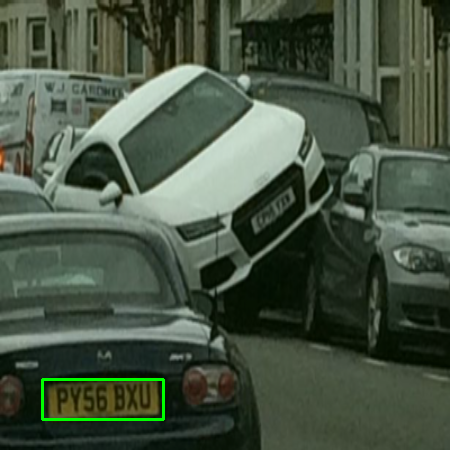

In [20]:
visualizer(new_data,11)

now data is ready, but some changes is required to give model

In [21]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [22]:
train_images = tf.data.Dataset.list_files('/content/aug_datas/new_images/*.png', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [23]:
label = "/content/aug_datas/new_annotations/augmented_image0_Cars1.json"
import tensorflow as tf
import xml.etree.ElementTree as ET

def load_labels(label_path):
    import xml.etree.ElementTree as ET

    def get_value(root, *args):
        element = root
        for tag in args:
            element = element.find(tag)
            if element is None:
                return None
        return element.text

    label = 0
    xml_data = tf.io.read_file(label_path)
    rt = 120/450
    def process_xml(xml_data):
        xml_string = xml_data.numpy().decode('utf-8')
        root = ET.fromstring(xml_string)

        xmin = int(round(float(get_value(root, 'object', 'bndbox', 'xmin'))*rt))
        ymin = int(round(float(get_value(root, 'object', 'bndbox', 'ymin'))*rt))
        xmax = int(round(float(get_value(root, 'object', 'bndbox', 'xmax'))*rt))
        ymax = int(round(float(get_value(root, 'object', 'bndbox', 'ymax'))*rt))
        bboxes = [xmin, ymin, xmax, ymax]

        return [label], bboxes

    return tf.py_function(process_xml, [xml_data], [tf.int32, tf.int32])



In [24]:
file_paths_dataset = tf.data.Dataset.list_files("/content/aug_datas/new_annotations/*.json", shuffle=False)
def process_file(file_path):
    file_name = tf.strings.split(file_path, os.path.sep)[-1]
    file_name = tf.strings.as_string(file_name)
    return file_name

In [25]:
train_labels = file_paths_dataset.map(load_labels)

In [26]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [27]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()

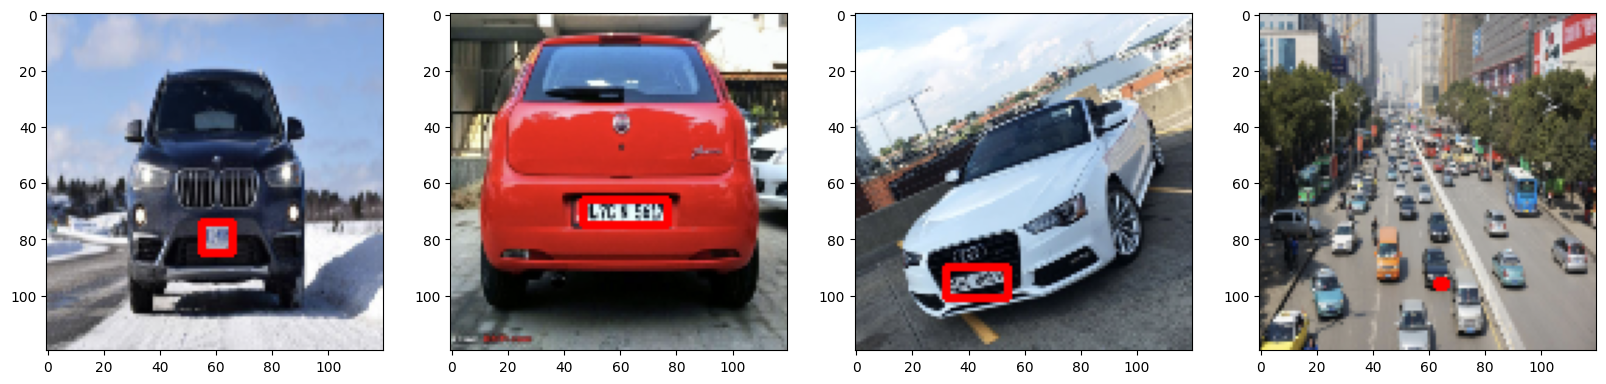

In [28]:
import matplotlib.pyplot as plt
import cv2

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    x1, y1, width, height = sample_coords

    x2 = x1 + width
    y2 = y1 + height

    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

    sample_image_rgb = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

    cv2.rectangle(sample_image_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)

    ax[idx].imshow(sample_image_rgb)


In [29]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [30]:
vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [31]:
def build_model():
    input_layer = Input(shape=(120,120,3))

    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [43]:
plaker = build_model()


In [33]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [34]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [35]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

    return delta_coord + delta_size

In [36]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [44]:
class Plaker(Model):
    def __init__(self, plaker,  **kwargs):
        super().__init__(**kwargs)
        self.model = plaker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):

        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss+0.5*batch_classloss

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)

        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [38]:
model = Plaker(plaker)


In [39]:
model.compile(opt, classloss, regressloss)


In [40]:
logdir='logs'


In [41]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


In [42]:
hist = model.fit(train, epochs=10, callbacks=[tensorboard_callback])


Epoch 1/10
1624/1624 [==============================] - 166s 71ms/step - total_loss: 74487.1469 - class_loss: 0.0013 - regress_loss: 74487.1463
Epoch 2/10
1624/1624 [==============================] - 141s 70ms/step - total_loss: 74497.6529 - class_loss: 0.0000e+00 - regress_loss: 74497.6529
Epoch 3/10
1624/1624 [==============================] - 147s 70ms/step - total_loss: 74480.2314 - class_loss: 0.0000e+00 - regress_loss: 74480.2314
Epoch 4/10
1624/1624 [==============================] - 148s 71ms/step - total_loss: 74504.7569 - class_loss: 0.0000e+00 - regress_loss: 74504.7569
Epoch 5/10
1624/1624 [==============================] - 148s 71ms/step - total_loss: 74481.0997 - class_loss: 0.0000e+00 - regress_loss: 74481.0997
Epoch 6/10
1624/1624 [==============================] - 141s 70ms/step - total_loss: 74490.2258 - class_loss: 0.0000e+00 - regress_loss: 74490.2258
Epoch 7/10
1624/1624 [==============================] - 141s 70ms/step - total_loss: 74506.1274 - class_loss: 0.0000

In [45]:
from tensorflow.keras.models import load_model
plaker.save('plaker.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [66]:
y_pred = plaker.predict(res[0])

1/1 [==============================] - 0s 32ms/step


In [68]:
y_pred = y_pred[1]*100

In [78]:
y_pred[0]

array([60.739563, 53.693653, 45.493576, 30.0482  ], dtype=float32)

In [80]:
y_pred.shape

(8, 4)

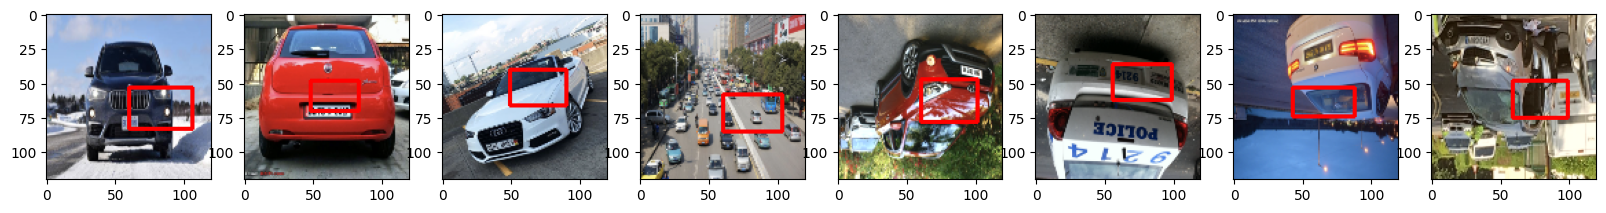

In [83]:
fig, ax = plt.subplots(ncols=8, figsize=(20,20))
for idx in range(8):
    sample_image = res[0][idx]

    x1, y1, width, height = y_pred[idx]

    x2 = x1 + width
    y2 = y1 + height

    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

    sample_image_rgb = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

    cv2.rectangle(sample_image_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)

    ax[idx].imshow(sample_image_rgb)